In [98]:
## imports 
# astro
from    astropy.wcs             import WCS
from    astropy.io              import fits
import  astropy.units           as u
from    astropy.nddata          import Cutout2D
from    astropy.coordinates     import SkyCoord
from    astropy.visualization   import (MinMaxInterval, PercentileInterval, ZScaleInterval, SqrtStretch, AsinhStretch, LogStretch, ImageNormalize)
# data 
import  numpy   as np
import  pandas  as pd
# plots
import  matplotlib.pyplot as plt

## file paths 
path_catalogs = 'C:\\Users\\polar\\OneDrive - The University of Kansas\\AGNerds\\Catalogs'
path_cutouts = 'C:\\Users\\polar\\OneDrive - The University of Kansas\\AGNerds\\AGNerds\\JWST_AGN_proj2\\Cutouts'

# Read Files

In [99]:
# read file to get agn info
df_agn = pd.read_csv(path_catalogs+'\\AGN_candidates.txt', sep=',')
# display(df_agn)

In [100]:
def getData(fitsFile):
    data = fits.getdata(fitsFile)
    header = fits.getheader(fitsFile)
    f = fits.open(fitsFile)
    wcs = WCS(f[1].header)
    f.close()
    return (data, header, wcs)

In [101]:
# get image data
data_cm1_f1000w, header_cm1_f1000w, wcs_cm1_f1000w = getData(path_catalogs+'\\ceers_miri1_f1000w_i2d.fits')
data_cm2_f1000w, header_cm2_f1000w, wcs_cm2_f1000w = getData(path_catalogs+'\\ceers_miri2_f1000w_i2d.fits')

data_cm1_f1280w, header_cm1_f1280w, wcs_cm1_f1280w = getData(path_catalogs+'\\ceers_miri1_f1280w_i2d.fits')
data_cm2_f1280w, header_cm2_f1280w, wcs_cm2_f1280w = getData(path_catalogs+'\\ceers_miri2_f1280w_i2d.fits')

data_cm1_f770w, header_cm1_f770w, wcs_cm1_f770w = getData(path_catalogs+'\\ceers_miri1_f770w_i2d.fits')
data_cm2_f770w, header_cm2_f770w, wcs_cm2_f770w = getData(path_catalogs+'\\ceers_miri2_f770w_i2d.fits')

# data_egs, header_egs, wcs_egs = getData(path_catalogs+'\\egs_all_wfc3_ir_f160w_030mas_v1.9_drz.fits')

Set DATE-AVG to '2022-06-21T19:01:47.926' from MJD-AVG.
Set DATE-END to '2022-06-21T19:17:17.099' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.743944 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725242515.981 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-21T23:48:57.498' from MJD-AVG.
Set DATE-END to '2022-06-22T00:04:15.579' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.782898 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725446993.656 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-21T19:37:34.014' from MJD-AVG.
Set DATE-END to '2022-06-21T19:52:51.177' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.748835 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725268421.305 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-22T00:24:36.184' from MJD-AVG.
Set DATE-END to '2022-06-22T00:39:55.224' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.787605 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725471424.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE

# Functions for Image Cutouts

In [102]:
def GetCutout(
    ra,     # right ascension [deg]
    dec,    # declination [deg]
    wcs,    # World Coordinate System
    data,   # image data
    dl=50   # cutout size 
):
    # get position on sky 
    coord = SkyCoord(ra*u.degree,dec*u.degree)
    x, y = wcs.world_to_pixel(coord)
    # make cutout 
    dl = 50
    cutout = Cutout2D(data, position=(x,y), size=(dl,dl), wcs=wcs, mode='partial')
    return(cutout)

In [103]:
def PlotCutout(
    ax,
    cutout,
    center, # dl/2
    title,  # title 
    useNorm=None,
    showGrid=False
) : 
    if(showGrid):
        # grid lines
        ax.grid(True, color='r', linestyle='--', linewidth=0.5)
    else:
        # hide ticks
        ax.set_xticks([])
        ax.set_yticks([])
    # hide axis lables
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    # mark center coord 
    circle = plt.Circle((center,center), 10, fc=(0,0,0,0), ec="red")
    ax.add_patch(circle)
    # set title
    ax.set_title(title,fontsize=14)
    # plot image
    if(useNorm == None) : 
        ax.imshow(cutout.data, origin='lower', cmap='gray')
    else:
        norm1 = ImageNormalize(cutout.data, interval=PercentileInterval(useNorm), stretch=AsinhStretch())
        ax.imshow(cutout.data, origin='lower', cmap='gray', norm=norm1)

In [104]:
def MakePlotOfSrc_OneBand(
    ra,     # right ascension [deg]
    dec,    # declination [deg]
    id,     # Candels ID 
    fagn,   # f(AGN)
    wcs1,   # World Coordinate System
    data1,  # image data
    band,   # title of subplot 
    useNorm=None,   # normalization percent interval
    showGrid=False,
    dl=50,  # cutout size  
    fileName=''     # name and path of file to save to
):
    # image cutout  
    cutout1 = GetCutout(ra,dec,wcs1,data1)

    # make figure 
    fig = plt.figure(figsize=(4,4.25), facecolor='white')
    if(showGrid):
        ax1 = fig.add_subplot(111, projection=cutout1.wcs)
        fig.supxlabel('RA')
        fig.supylabel('Dec')
    else:
        ax1 = fig.add_subplot(111)
        
    # plot image cutout on axis 
    PlotCutout(ax1,cutout1,dl/2,band,useNorm,showGrid)
   
    # labels
    fig.suptitle('Candels ID: '+str(id)+', f(AGN) = '+str(fagn), fontsize=16)

    # save 
    if(fileName):
        plt.savefig(    fileName,
                        bbox_inches ="tight",
                        pad_inches=0.05,
                        facecolor='w',
                        edgecolor='w'
        )

In [105]:
def MakePlotOfSrc_ThreeBands(
    ra,     # right ascension [deg]
    dec,    # declination [deg]
    id,     # Candels ID 
    fagn,   # f(AGN)
    wcs1,  wcs2,  wcs3,    # World Coordinate System
    data1, data2, data3,   # image data
    band1, band2, band3,   # title of subplot 
    useNorm=None,   # normalization percent interval
    showGrid=False,
    dl=50,  # cutout size  
    fileName=''     # name and path of file to save to
):
    # image cutout  
    cutout1 = GetCutout(ra,dec,wcs1,data1)
    cutout2 = GetCutout(ra,dec,wcs2,data2)
    cutout3 = GetCutout(ra,dec,wcs3,data3)

    # make figure 
    fig = plt.figure(figsize=(12,4), facecolor='white')
    if(showGrid):
        ax1 = fig.add_subplot(131, projection=cutout1.wcs)
        ax2 = fig.add_subplot(132, projection=cutout2.wcs)
        ax3 = fig.add_subplot(133, projection=cutout3.wcs)
        fig.supxlabel('RA')
        fig.supylabel('Dec')
    else:
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)

    # plot image cutout on axis 
    PlotCutout(ax1,cutout1,dl/2,'f770w', useNorm,showGrid)
    PlotCutout(ax2,cutout2,dl/2,'f1000w',useNorm,showGrid)
    PlotCutout(ax3,cutout3,dl/2,'f1280w',useNorm,showGrid)
    
    # labels
    fig.suptitle('Candels ID: '+str(id)+', f(AGN) = '+str(fagn), fontsize=16)

    # save 
    if(fileName):
        plt.savefig(    fileName,
                        bbox_inches ="tight",
                        pad_inches=0.05,
                        facecolor='w',
                        edgecolor='w'
        )

# Plot Single Source

In [106]:
# example source
i = 1
ra  = df_agn.at[i,"RA"]
dec = df_agn.at[i,"Dec"]
id  = df_agn.at[i,"Candels ID"]
fagn = df_agn.at[i,"f(AGN)"]
display(df_agn.iloc[[i]])


,Field,Candels ID,RA,Dec,f(AGN)
1,miri1,25979,215.14189,53.057549,0.8


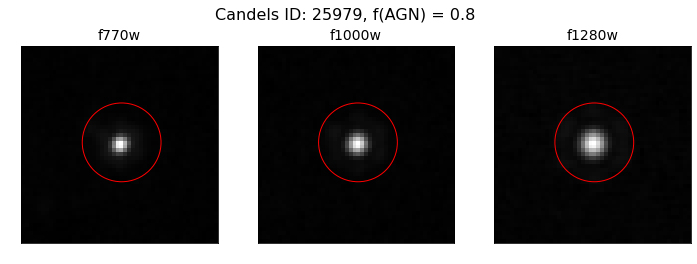

In [107]:
# miri 1
# # i must be for miri 1 src
MakePlotOfSrc_ThreeBands(
    ra,
    dec,
    id,
    fagn,
    wcs_cm1_f770w, wcs_cm1_f1000w, wcs_cm1_f1280w,
    data_cm1_f770w, data_cm1_f1000w, data_cm1_f1280w,
    'f770w', 'f1000w', 'f1280w',
    # useNorm=98,
    # fileName=path_cutouts+'\\test1.png'
)

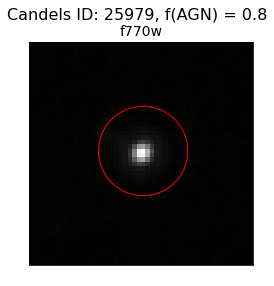

In [108]:
MakePlotOfSrc_OneBand(
    ra,
    dec,
    id,
    fagn,
    wcs_cm1_f770w,
    data_cm1_f770w,
    'f770w',
    # useNorm=98,
    # fileName=path_cutouts+'\\test2.png'
)

# Make Cutouts for All Sources

C:\Users\polar\AppData\Local\Temp\ipykernel_6636\3718574013.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,4), facecolor='white')


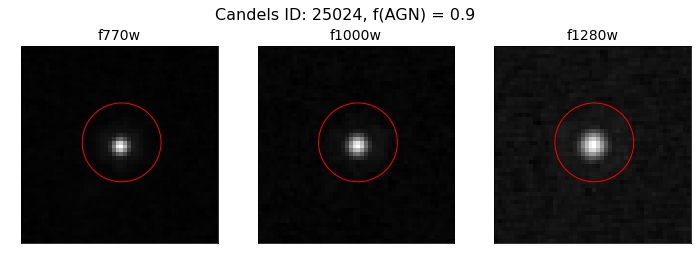

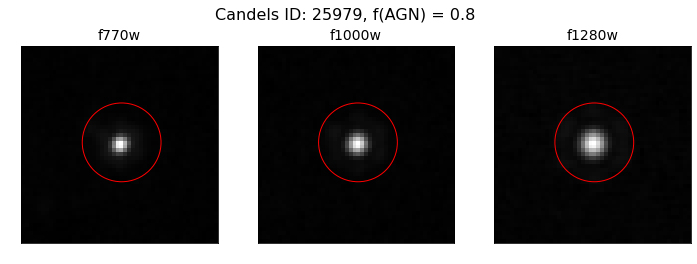

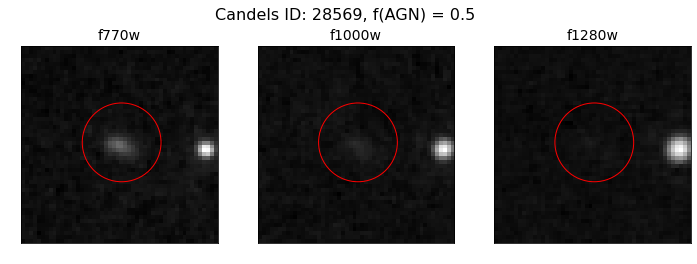

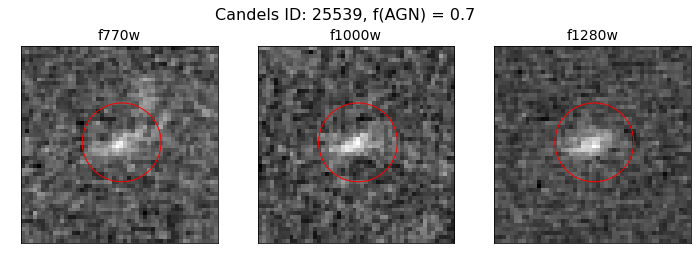

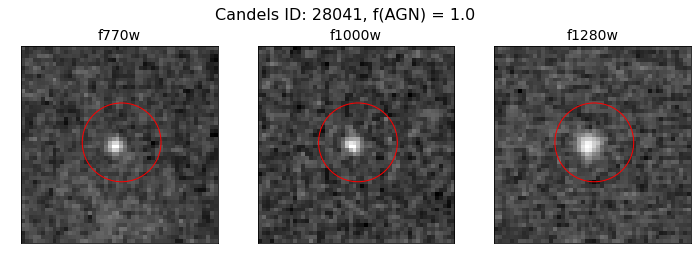

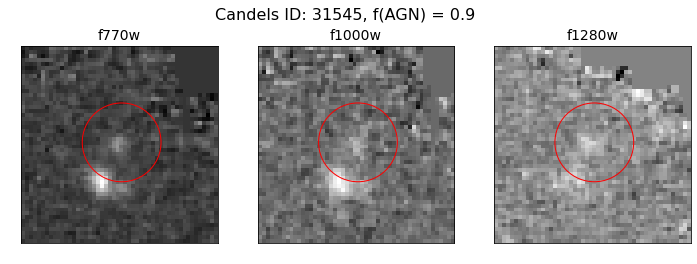

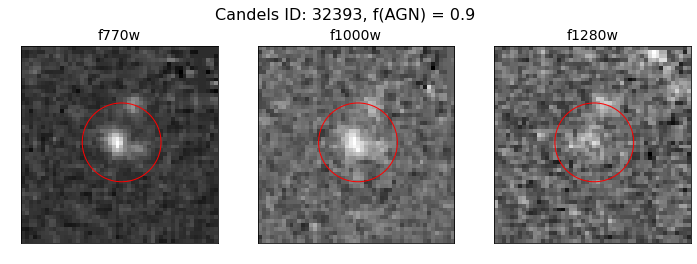

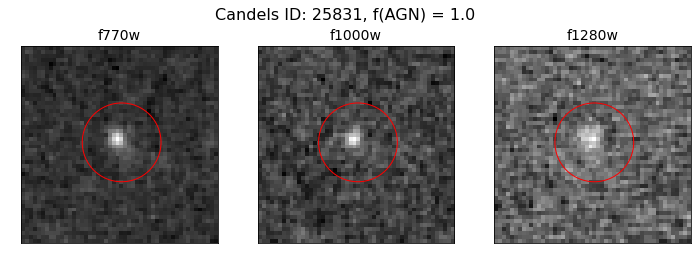

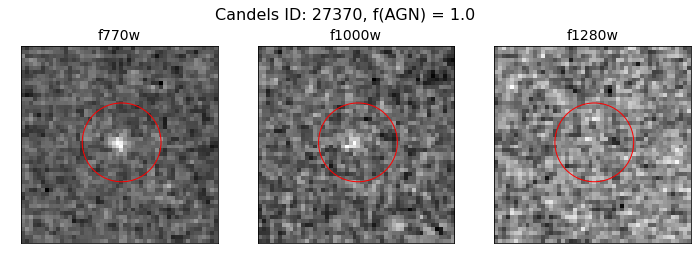

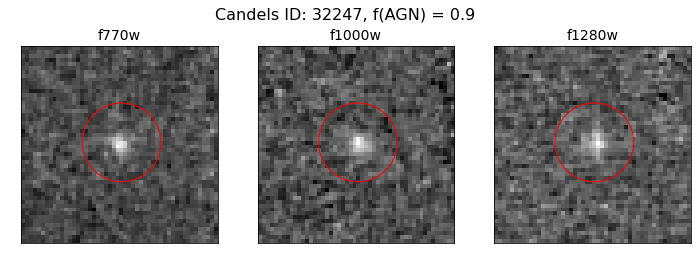

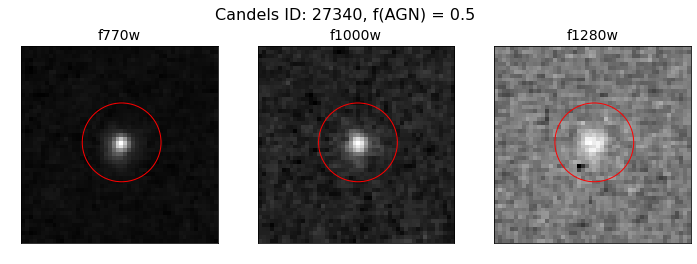

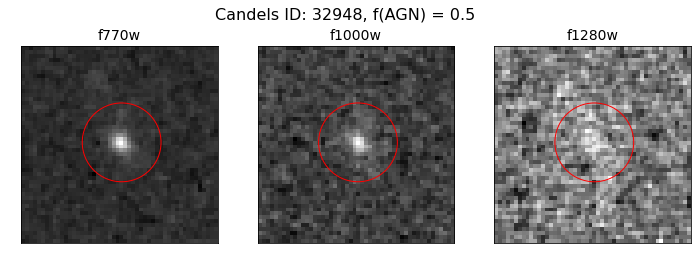

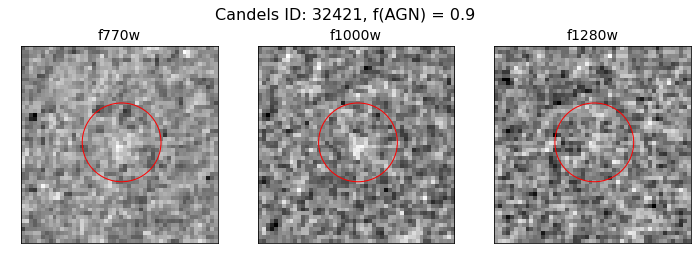

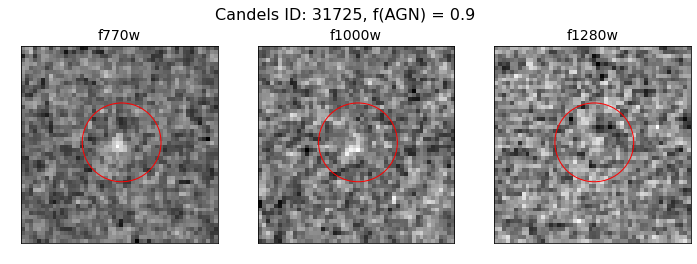

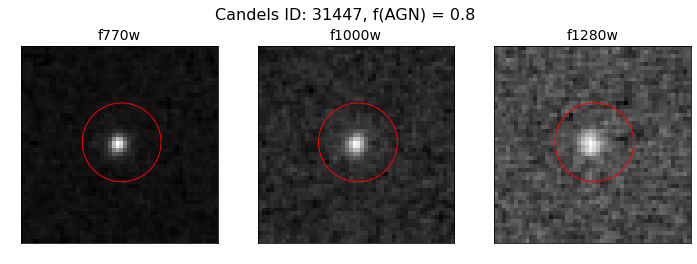

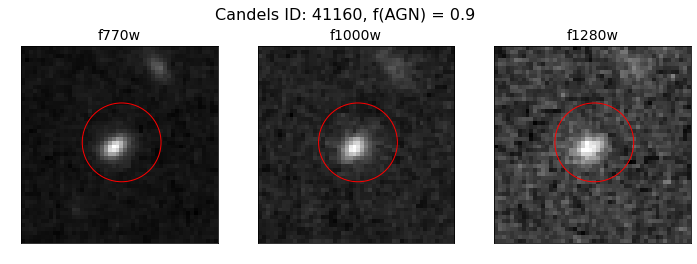

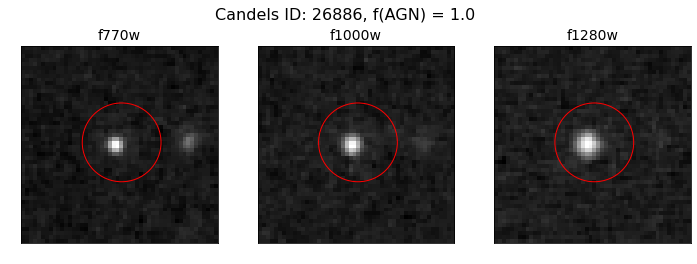

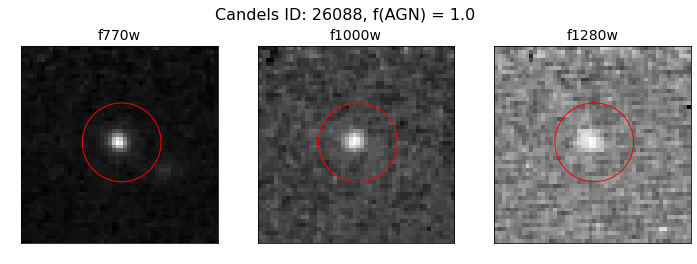

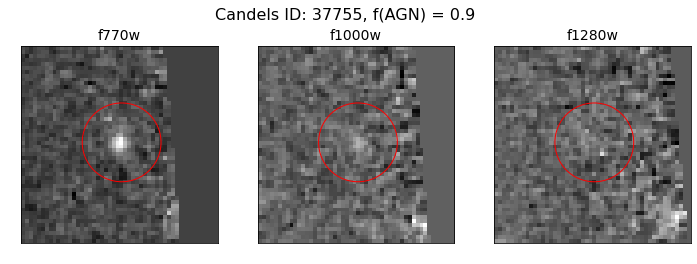

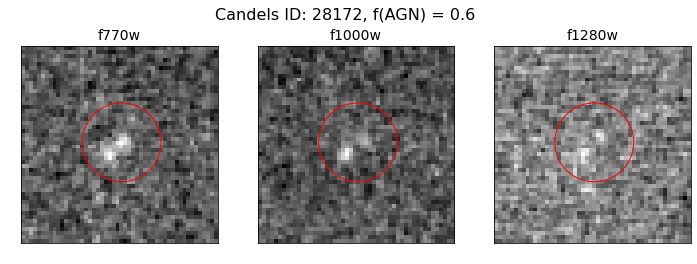

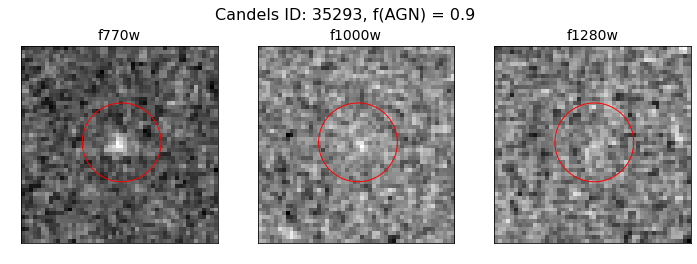

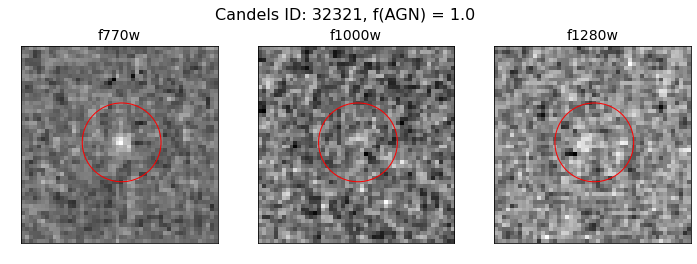

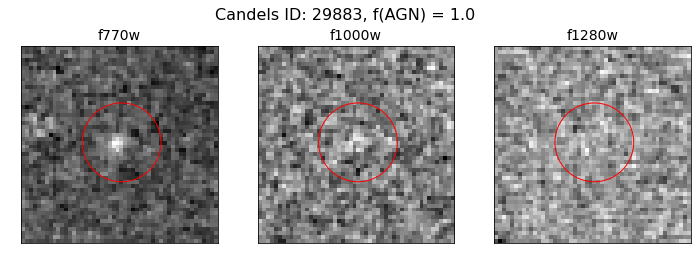

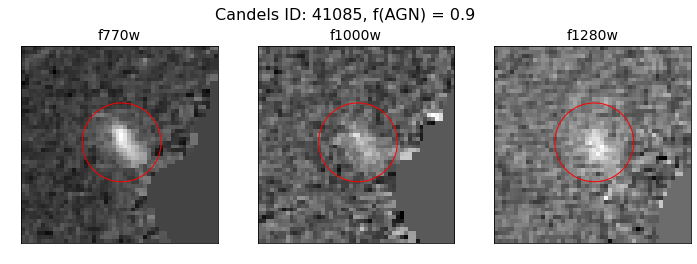

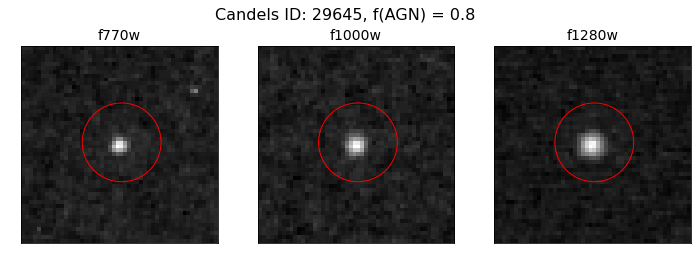

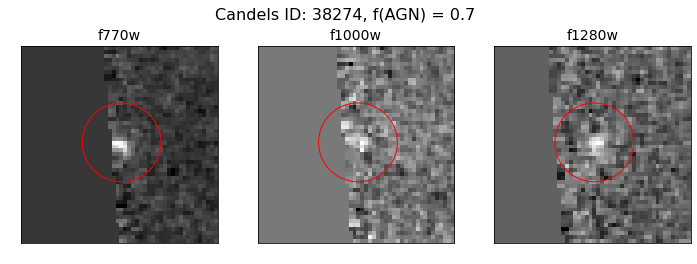

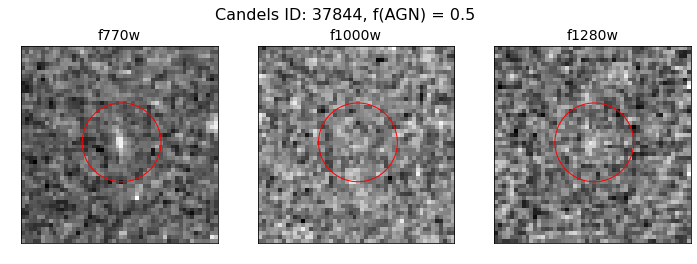

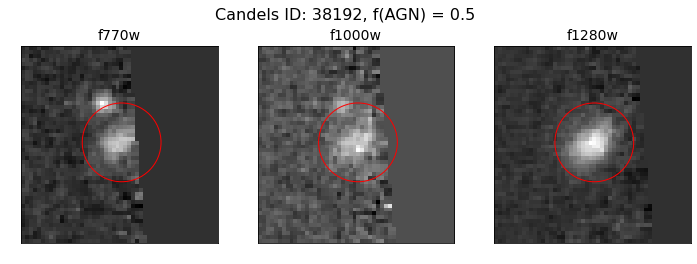

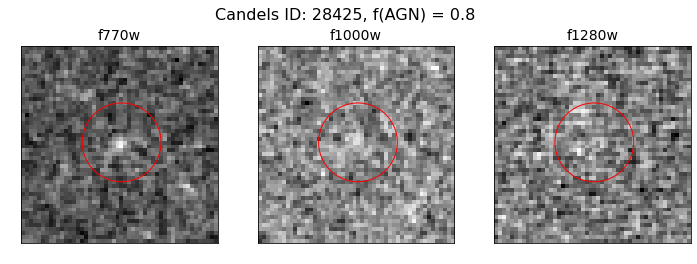

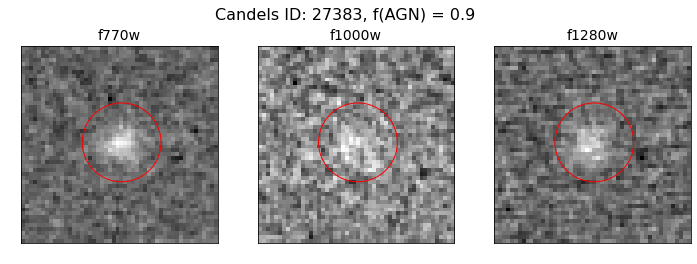

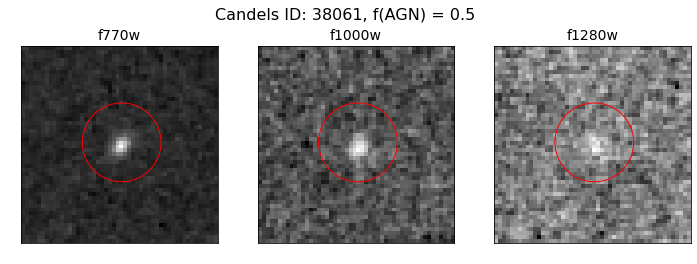

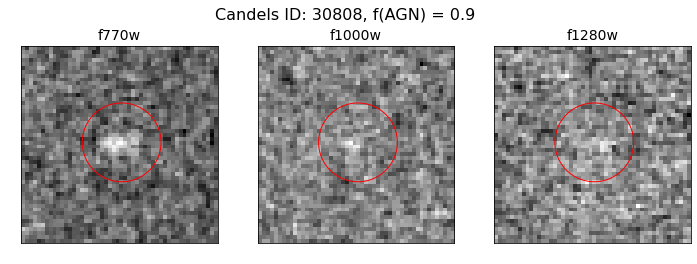

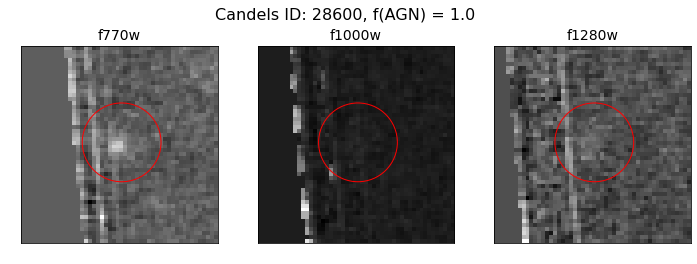

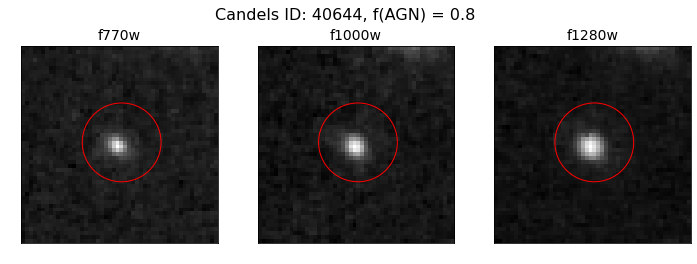

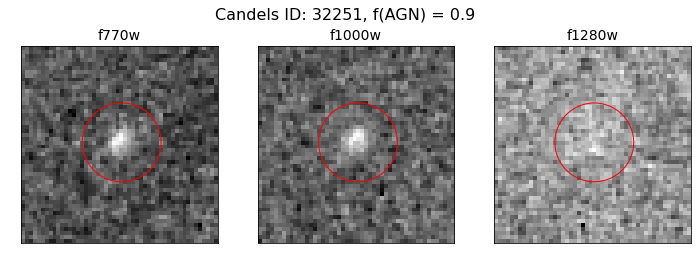

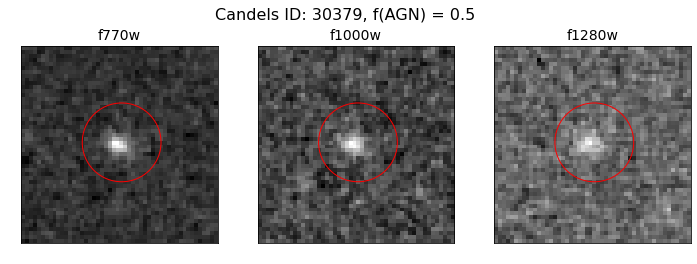

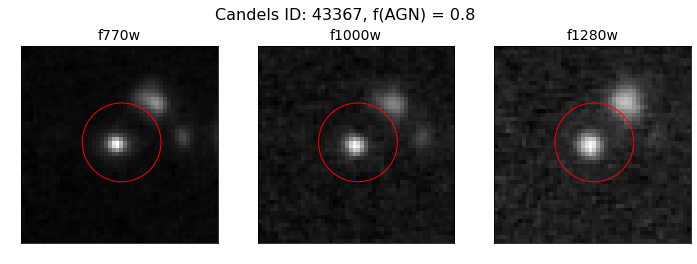

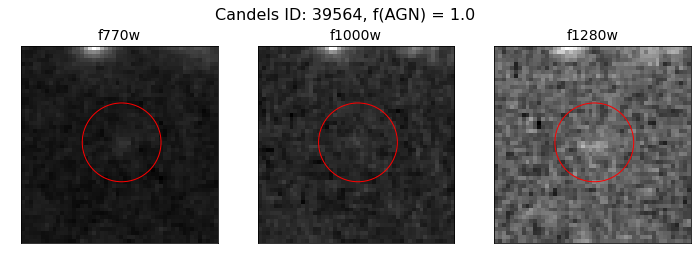

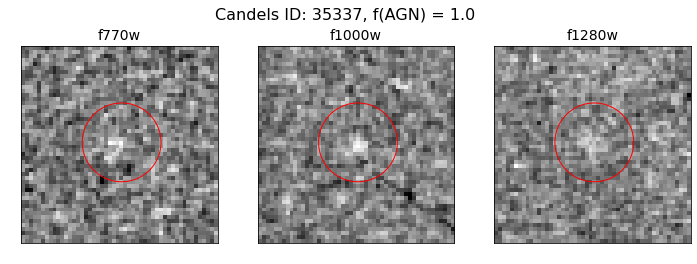

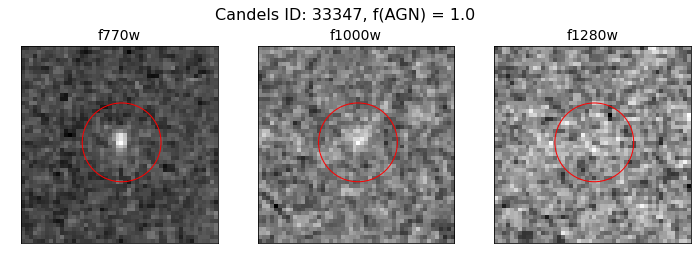

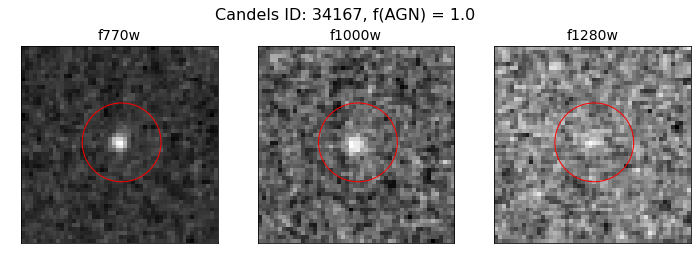

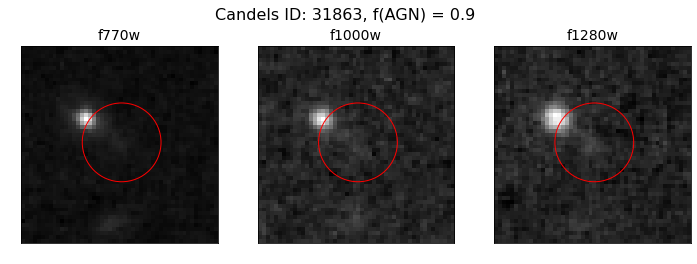

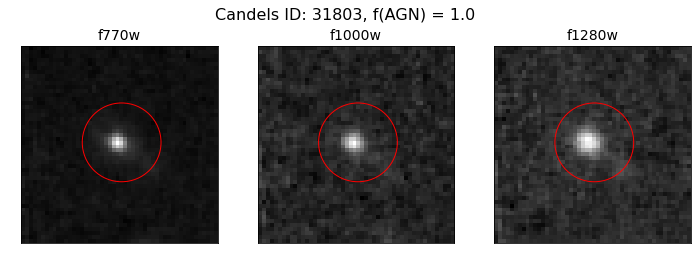

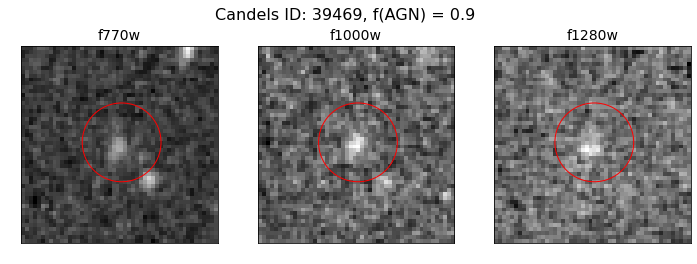

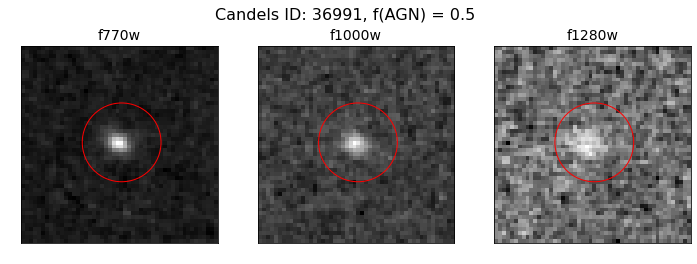

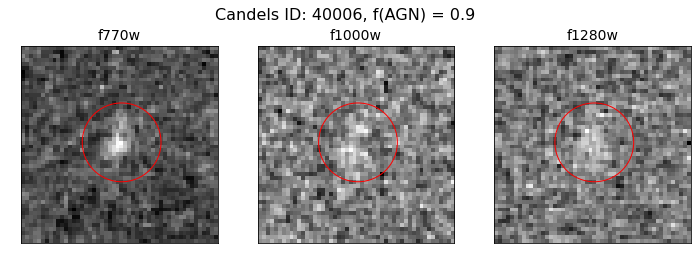

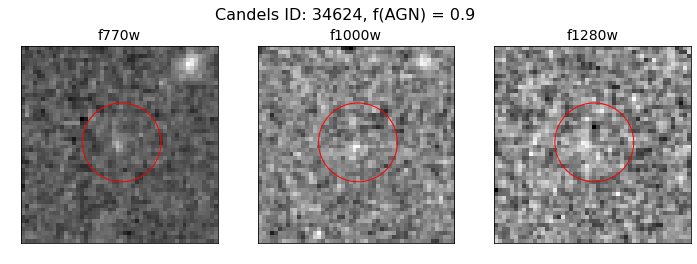

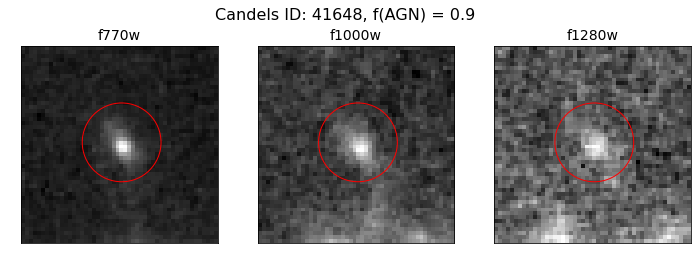

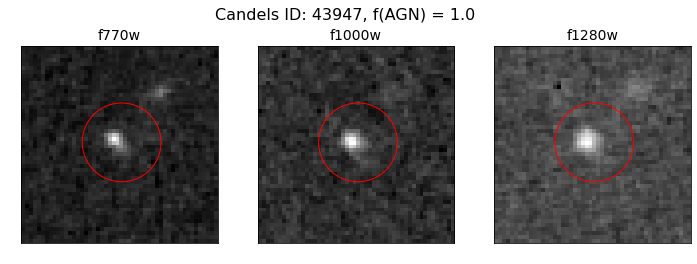

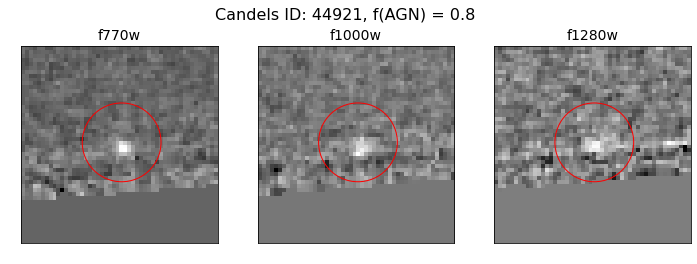

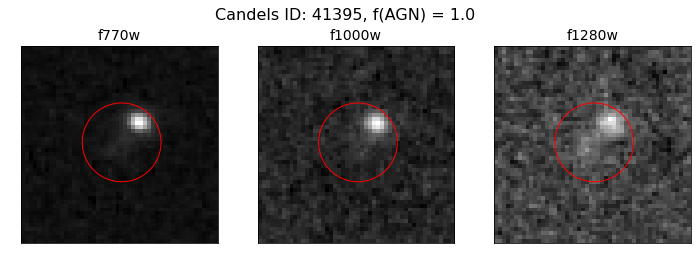

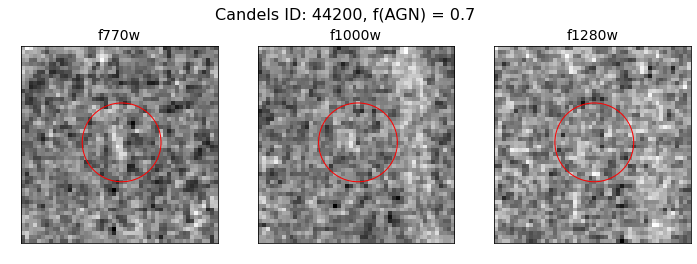

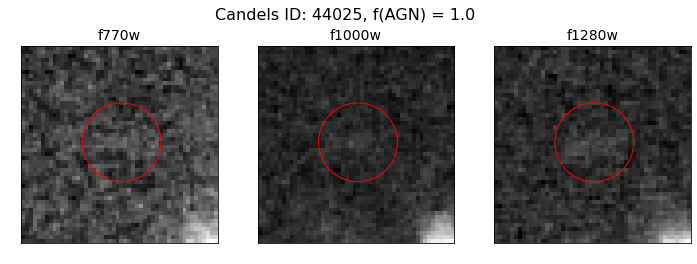

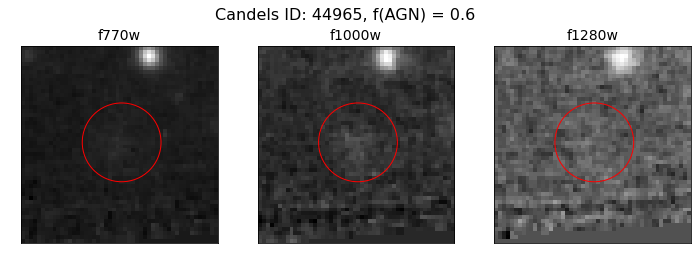

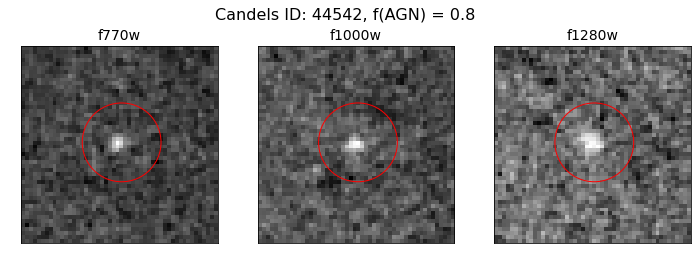

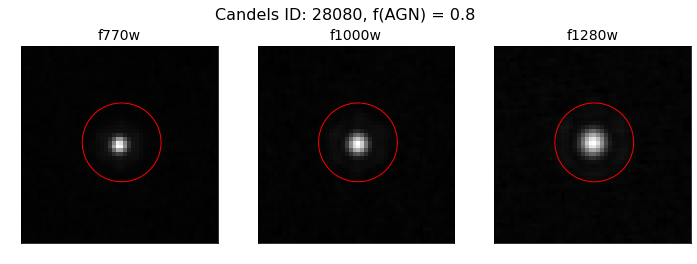

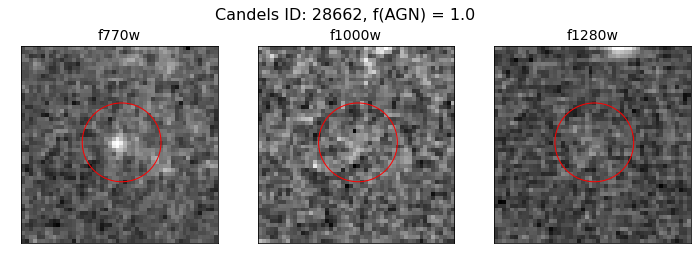

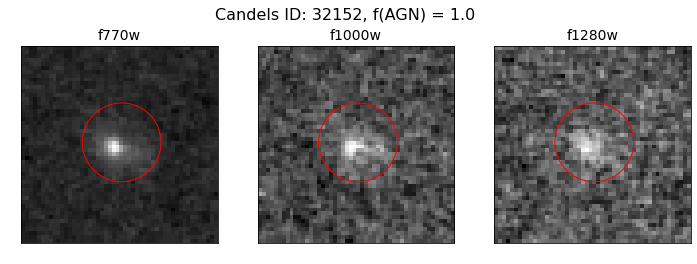

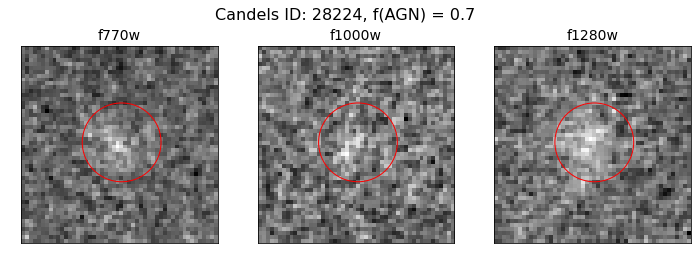

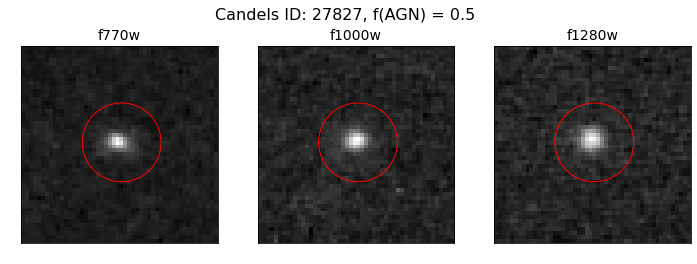

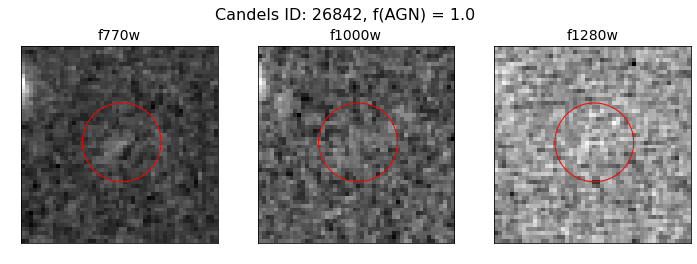

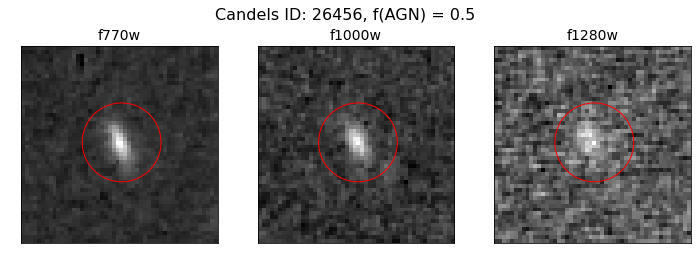

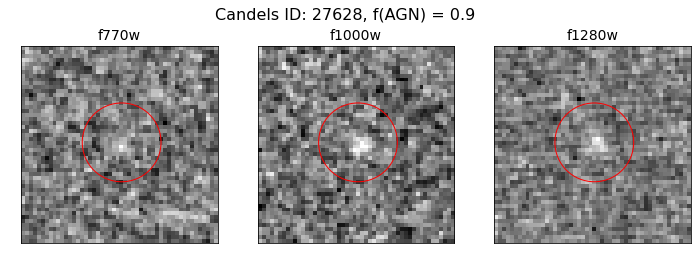

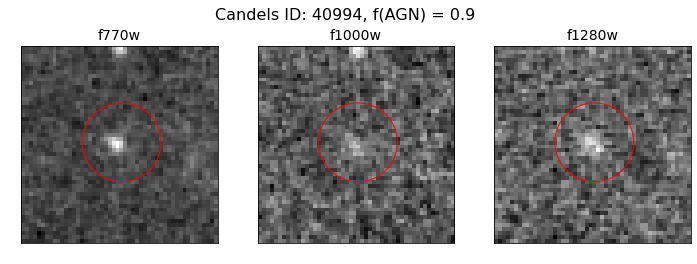

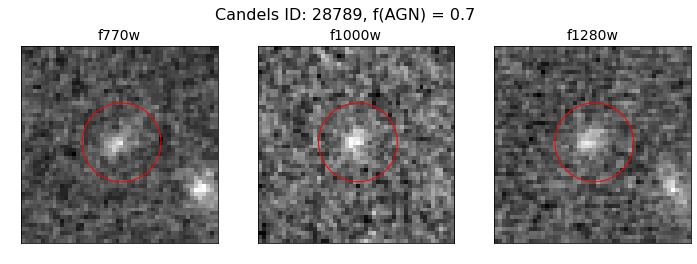

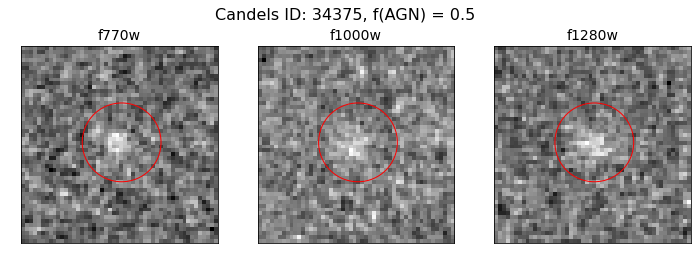

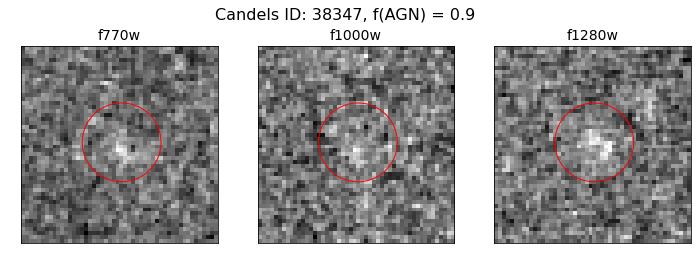

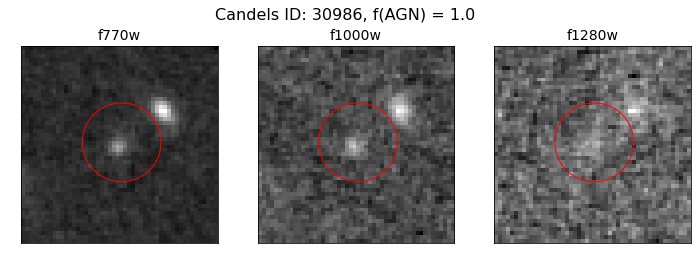

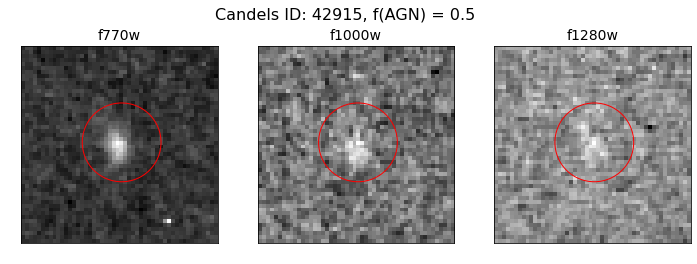

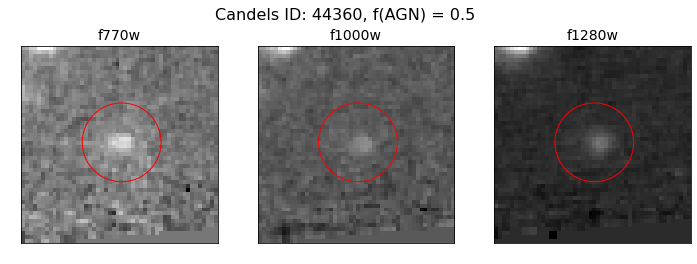

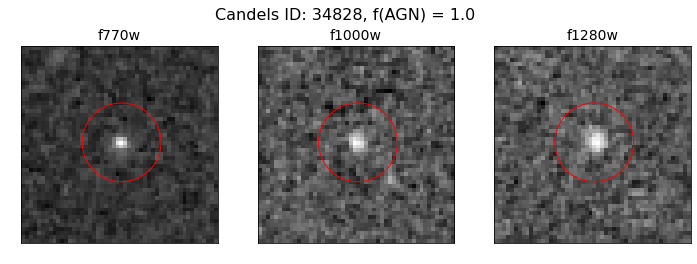

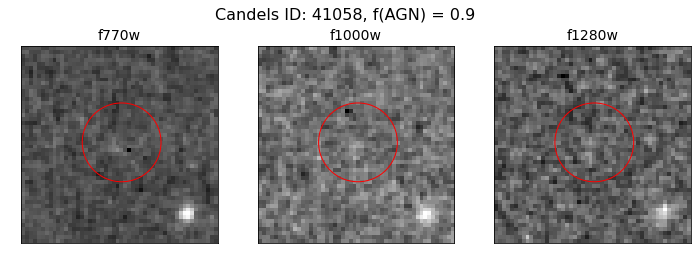

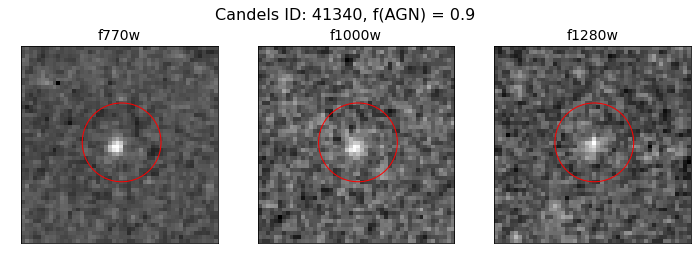

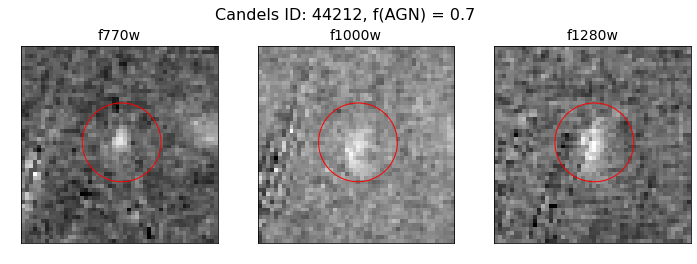

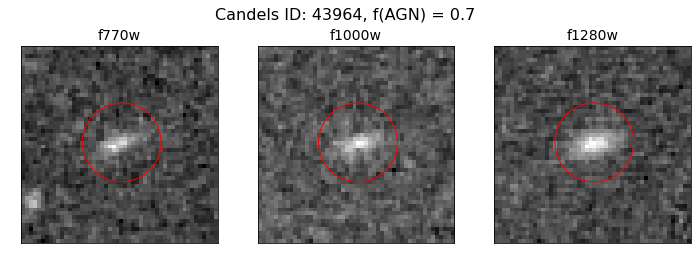

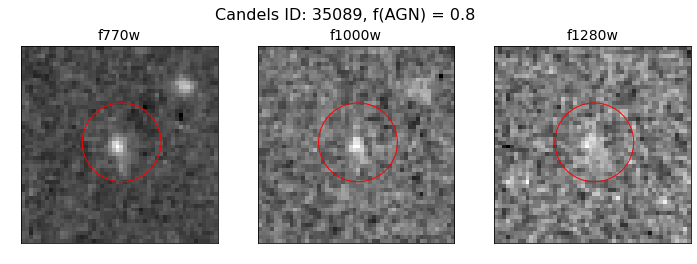

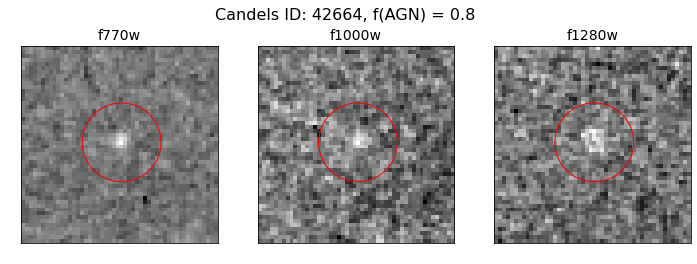

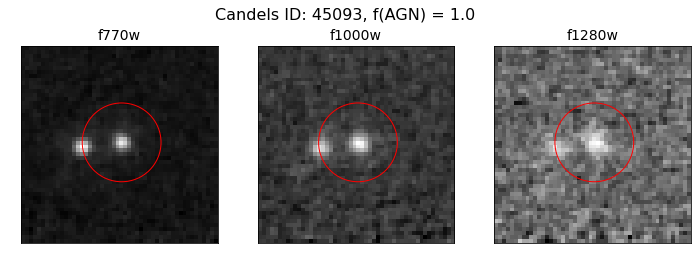

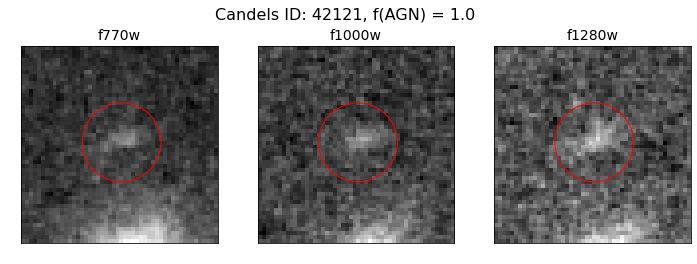

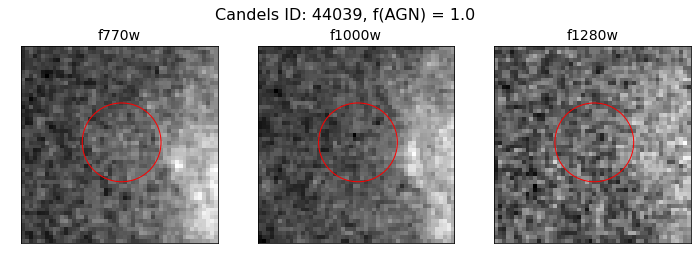

In [109]:
for index, row in df_agn.iterrows():
    # determine field of JWST MIRI source
    if(row['Field']=='miri1'):
        wcs_f770w  = wcs_cm1_f770w
        wcs_f1000w = wcs_cm1_f1000w
        wcs_f1280w = wcs_cm1_f1280w
        data_f770w  = data_cm1_f770w
        data_f1000w = data_cm1_f1000w
        data_f1280w = data_cm1_f1280w
    elif(row['Field']=='miri2'):
        wcs_f770w  = wcs_cm2_f770w
        wcs_f1000w = wcs_cm2_f1000w
        wcs_f1280w = wcs_cm2_f1280w
        data_f770w  = data_cm2_f770w
        data_f1000w = data_cm2_f1000w
        data_f1280w = data_cm2_f1280w
    else:
        print('Source at index'+str(index)+' is not miri 1 or 2.')
        continue
    
    try:
        # plot 
        MakePlotOfSrc_ThreeBands(
            row['RA'],
            row['Dec'],
            row['Candels ID'],
            row['f(AGN)'],
            wcs_f770w, wcs_f1000w, wcs_f1280w,
            data_f770w, data_f1000w, data_f1280w,
            'f770w', 'f1000w', 'f1280w',
            # useNorm=98,
            fileName=path_cutouts+'\\'+str(row['Field'])+'_'+str(row['Candels ID'])+'.png'
        )
    except Exception as e: 
        print(e,'\tError occured on index: ', index)
